In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Alerting ClickHouse.csv')
df['hours'] = pd.to_datetime(df['hours'], format='%d/%m/%y %H:%M')
df = df.sort_values(by = 'hours').reset_index(drop = True)

In [3]:
df.head()

,hours,count_unique_user_id,count_like,count_view
0,2023-07-03 00:00:00,14,7,15
1,2023-07-03 01:00:00,26,4,28
2,2023-07-03 02:00:00,16,5,19
3,2023-07-03 03:00:00,11,0,11
4,2023-07-03 04:00:00,14,2,16


In [4]:
df['hours'].max()

Timestamp('2023-10-06 21:00:00')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   hours                 2302 non-null   datetime64[ns]
 1   count_unique_user_id  2302 non-null   int64         
 2   count_like            2302 non-null   int64         
 3   count_view            2302 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 72.1 KB


In [6]:
df.describe()

,count_unique_user_id,count_like,count_view
count,2302.000000,2302.000000,2302.000000
mean,1406.814509,4828.251086,22898.336229
std,667.154743,2556.600962,12182.828968
min,11.000000,0.000000,11.000000
25%,863.250000,2934.500000,13761.250000
50%,1413.500000,4666.500000,21891.500000
75%,2014.500000,6326.750000,29995.750000
max,3053.000000,16821.000000,78828.000000


In [8]:
class Season_anomaly_detector:
    def __init__(self, low_limit, high_limit, method, window, step): 
        if method not in ['sigma', 'iqr']:
            raise ValueError('Допустимые значения метода: "sigma", "iqr"')
        self.method = method
        self.low_limit = low_limit
        self.high_limit = high_limit
        self.window = window
        self.step = step
    
    def anomaly_detected(self, dataframe, date_column, anomaly_column, plot_flag = False):    
        dataframe = dataframe.copy()
        data = dataframe[anomaly_column].values
        result_array = []
        low_high_list = []
        for _ in range(self.window * self.step):
            result_array.append(False)
            low_high_list.append(0)
        if dataframe.shape[0] < self.window * self.step:
            raise ValueError(f"Слишком маленький размер выборки, введите значение не меньше {self.window * self.step}")           
        for elem in range(self.window * self.step, len(data)):
            choosing_interval = data[elem - self.window * self.step: elem - self.step + 1: self.step]
            if self.method == 'sigma':
                low_treshhold, high_treshhold = self._sigma_interval(choosing_interval)
            else:
                low_treshhold, high_treshhold = self._iqr_interval(choosing_interval)
            if data[elem] >= low_treshhold and data[elem] <= high_treshhold:
                result_array.append(False)
                low_high_list.append(0)
            elif data[elem] < low_treshhold:
                result_array.append(True)
                low_high_list.append(-1)
            elif data[elem] > high_treshhold:
                result_array.append(True)
                low_high_list.append(1)
        dataframe['anomaly_flag'] = np.array(result_array)
        dataframe['change_sign'] = np.array(low_high_list)
        if plot_flag:
            plt.plot(dataframe[date_column], dataframe[anomaly_column])
            plt.scatter(dataframe[dataframe['anomaly_flag']][date_column], dataframe[dataframe['anomaly_flag']][anomaly_column], color= 'r')
        return dataframe
    
    def _iqr_interval(self, data):
        quan_25 = np.quantile(data, 0.25)
        quan_75 = np.quantile(data, 0,75)
        iqr = quan_75 - quan_25
        min_iqr = quan_25 - iqr * self.low_limit
        max_iqr = quan_75 + iqr * self.high_limit
        if min_iqr < 0:
            min_iqr = 0
        return min_iqr, max_iqr
    
    def _sigma_interval(self, data):
        sigma = data.std()
        mean = data.mean()
        min_limit = mean - sigma * self.low_limit
        max_limit = mean + sigma * self.high_limit
        if min_limit < 0:
            min_limit = 0
        return min_limit, max_limit

,hours,count_unique_user_id,count_like,count_view,anomaly_flag,change_sign
2102,2023-09-28 14:00:00,2175,4827,22199,False,0
2103,2023-09-28 15:00:00,2168,5002,22947,False,0
2104,2023-09-28 16:00:00,2308,5017,23564,False,0
2105,2023-09-28 17:00:00,2424,5890,27035,False,0
2106,2023-09-28 18:00:00,2579,6206,28700,False,0
...,...,...,...,...,...,...
2297,2023-10-06 17:00:00,2561,9074,42101,True,1
2298,2023-10-06 18:00:00,2675,9832,46057,True,1
2299,2023-10-06 19:00:00,2597,10493,48610,True,1
2300,2023-10-06 20:00:00,2372,9049,43835,True,1


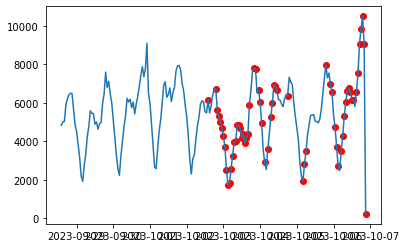

In [9]:
detected = Season_anomaly_detector(1, 1, 'sigma', 4, 24)
detected.anomaly_detected(df[df['hours'] > (df['hours'].max() - pd.Timedelta(200, 'hours'))], 'hours', 'count_like', True)

In [10]:
detected.anomaly_detected(df, 'hours', 'count_like')

,hours,count_unique_user_id,count_like,count_view,anomaly_flag,change_sign
0,2023-07-03 00:00:00,14,7,15,False,0
1,2023-07-03 01:00:00,26,4,28,False,0
2,2023-07-03 02:00:00,16,5,19,False,0
3,2023-07-03 03:00:00,11,0,11,False,0
4,2023-07-03 04:00:00,14,2,16,False,0
...,...,...,...,...,...,...
2297,2023-10-06 17:00:00,2561,9074,42101,True,1
2298,2023-10-06 18:00:00,2675,9832,46057,True,1
2299,2023-10-06 19:00:00,2597,10493,48610,True,1
2300,2023-10-06 20:00:00,2372,9049,43835,True,1


In [11]:
df[(df['hours'] > df['hours'].max() - pd.Timedelta(24,'hours'))]

,hours,count_unique_user_id,count_like,count_view
2278,2023-10-05 22:00:00,1923,6950,34179
2279,2023-10-05 23:00:00,1649,6549,31113
2280,2023-10-06 00:00:00,1339,5359,24336
2281,2023-10-06 01:00:00,1214,4716,21688
2282,2023-10-06 02:00:00,944,3706,16351
2283,2023-10-06 03:00:00,709,2720,12253
2284,2023-10-06 04:00:00,698,2463,11169
2285,2023-10-06 05:00:00,970,3474,15778
2286,2023-10-06 06:00:00,1267,4272,19637
2287,2023-10-06 07:00:00,1542,5289,24104


In [14]:
metrics = ['count_like', 'count_view']

In [15]:
detected = Season_anomaly_detector(1, 2, 'sigma', 4, 24)
for metric in metrics:
    anomaly_df = detected.anomaly_detected(df, 'hours', metric)
    last_24_hours_df = anomaly_df[(anomaly_df['hours'] > anomaly_df['hours'].max() - pd.Timedelta(24,'hours'))]
    count_anomaly = last_24_hours_df['anomaly_flag'].sum()
    part_anomaly = round(last_24_hours_df['anomaly_flag'].mean() * 100, 2)
    anomaly_time = last_24_hours_df[last_24_hours_df['anomaly_flag']][['hours', 'change_sign']]
    part_high_anomaly = round((last_24_hours_df['change_sign'] == 1).mean() * 100, 2)
    part_low_anomaly = round((last_24_hours_df['change_sign'] == -1).mean() * 100, 2)
    
    print(f'За последние 24 часа метрика {metric} дала аномальные показатели {count_anomaly} раз, это составляет {part_anomaly}% от всех данных за последние сутки.') 
    print(f'Доля повышенных аномалий составляет {part_high_anomaly}%.')
    print(f'Доля пониженных аномалий составляет {part_low_anomaly}%.')
    print(f'Аномалии происходили в следующие часы:\n{anomaly_time}\n')

За последние 24 часа метрика count_like дала аномальные показатели 7 раз, это составляет 29.17% от всех данных за последние сутки.
Доля повышенных аномалий составляет 25.0%.
Доля пониженных аномалий составляет 4.17%.
Аномалии происходили в следующие часы:
                   hours  change_sign
2295 2023-10-06 15:00:00            1
2296 2023-10-06 16:00:00            1
2297 2023-10-06 17:00:00            1
2298 2023-10-06 18:00:00            1
2299 2023-10-06 19:00:00            1
2300 2023-10-06 20:00:00            1
2301 2023-10-06 21:00:00           -1

За последние 24 часа метрика count_view дала аномальные показатели 7 раз, это составляет 29.17% от всех данных за последние сутки.
Доля повышенных аномалий составляет 25.0%.
Доля пониженных аномалий составляет 4.17%.
Аномалии происходили в следующие часы:
                   hours  change_sign
2295 2023-10-06 15:00:00            1
2296 2023-10-06 16:00:00            1
2297 2023-10-06 17:00:00            1
2298 2023-10-06 18:00:00       